In [64]:
import sys
import inspect
import os
import numpy as np
import pandas as pd
import math
import bisect
import matplotlib.pyplot as plt
import seaborn as sb
import ast
from scipy import stats as st

In [2]:
trials = pd.read_csv("./data/celine/main/trials.csv")

In [41]:
trials_force_answer = (trials[['trial_burst_force', 'trial_burst_time','subj_answer']][trials['subj_answer'].notnull()])
trials_force_answer["trial_burst_force"] = trials_force_answer["trial_burst_force"].abs()
display(trials_force_answer)
trials_force_answer.subj_answer.unique()

,trial_burst_force,trial_burst_time,subj_answer
1,0,0.00,0.0
3,0,0.00,0.0
5,24,0.13,3.0
6,24,0.13,3.0
9,0,0.00,1.0
...,...,...,...
295,15,0.13,1.0
296,0,0.00,0.0
297,24,0.09,2.0
298,0,0.00,0.0


array([0., 3., 1., 2.])

## Burst force und subjective answer

In [50]:
# Korrelation zwischen burst force und subjective answer berechnen
res_force_answer_spearmanr = st.spearmanr(trials_force_answer['trial_burst_force'].abs(), trials_force_answer['subj_answer'])
print(f"Korr zwischen |burst_force| und subjective answer:\n{res_force_answer_spearmanr}")
res_time_answer_spearmanr = st.spearmanr(trials_force_answer['trial_burst_time'], trials_force_answer['subj_answer'])
print(f"Korr zwischen |burst_time| und subjective answer:\n{res_time_answer_spearmanr}")

# Permutation test for p because of small batch size
def statistic(x):  # permute only `x`
    return st.spearmanr(x, trials_force_answer['subj_answer']).statistic
res_exact = st.permutation_test((trials_force_answer['trial_burst_force'].abs(),), statistic, permutation_type='pairings')

print(f"Permutation test p-Wert: {res_exact.pvalue}")

Korr zwischen |burst_force| und subjective answer:
SignificanceResult(statistic=0.35785359325419386, pvalue=3.010700760038783e-07)
Korr zwischen |burst_time| und subjective answer:
SignificanceResult(statistic=0.30762814191143206, pvalue=1.2808282103468508e-05)
Permutation test p-Wert: 0.0002


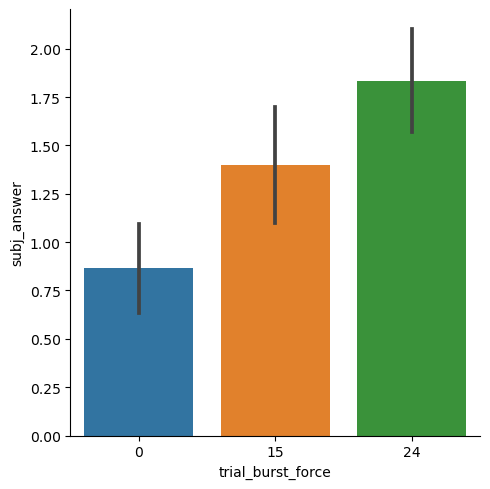

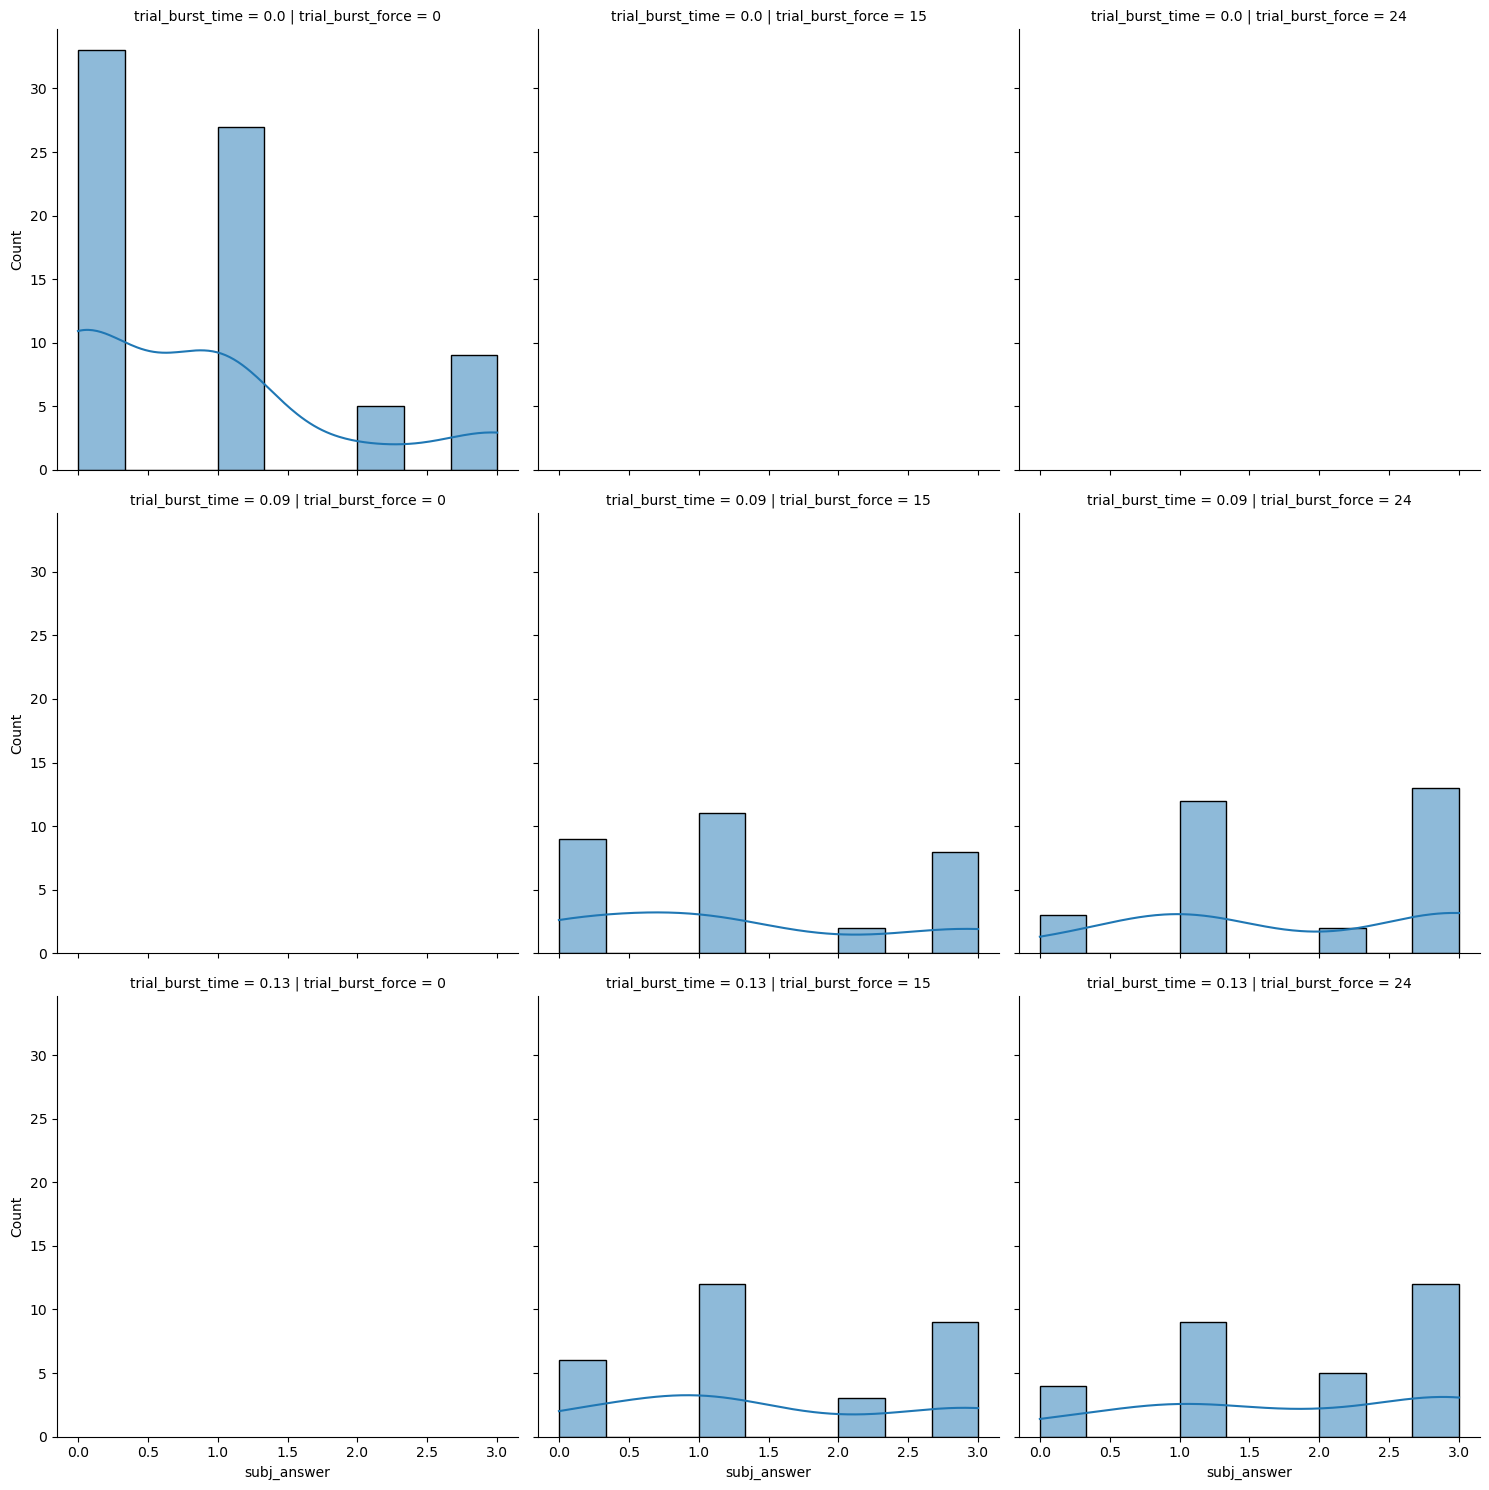

In [51]:
# Histogramme
sb.catplot(data=trials_force_answer, kind="bar", x="trial_burst_force", y="subj_answer")

trials_force_answer_bin = trials_force_answer.copy()
trials_force_answer_bin['trial_burst_force'] = trials_force_answer_bin.trial_burst_force.apply(lambda x: 1 if x > 0 else 0)
sb.displot(data=trials_force_answer, x="subj_answer", col="trial_burst_force", row="trial_burst_time", kde=True)

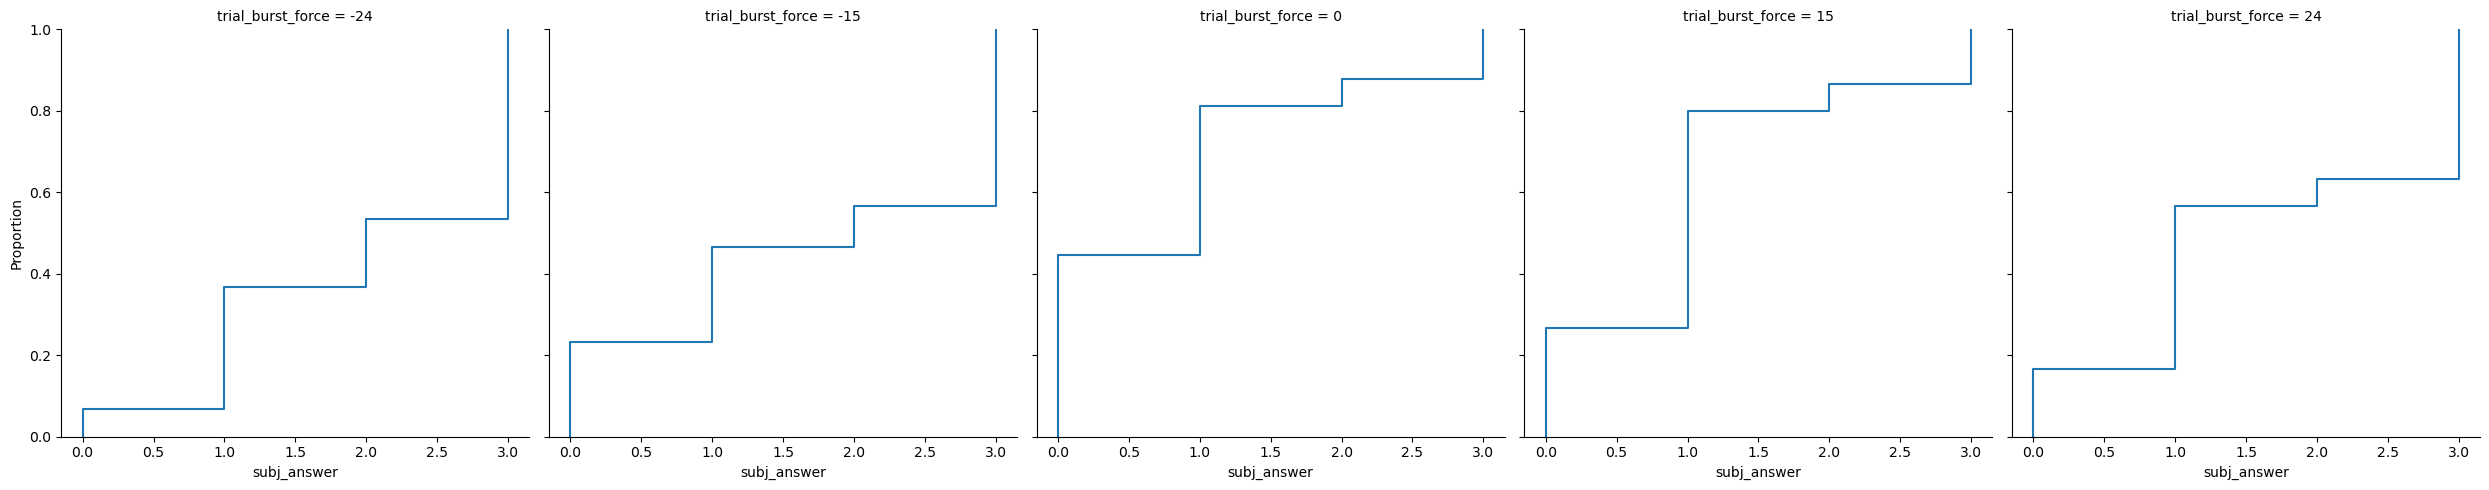

In [143]:
sb.displot(data=trials, x="subj_answer", col="trial_burst_force", kind="ecdf")

## EDA data

/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


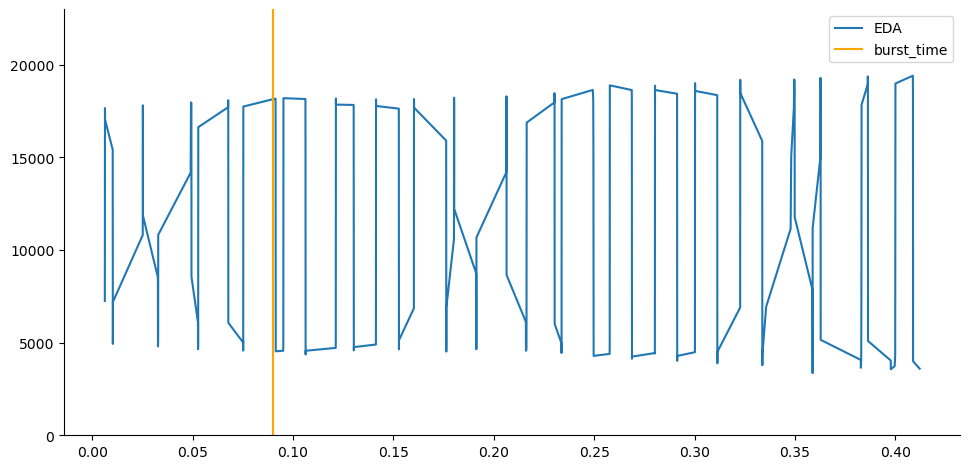

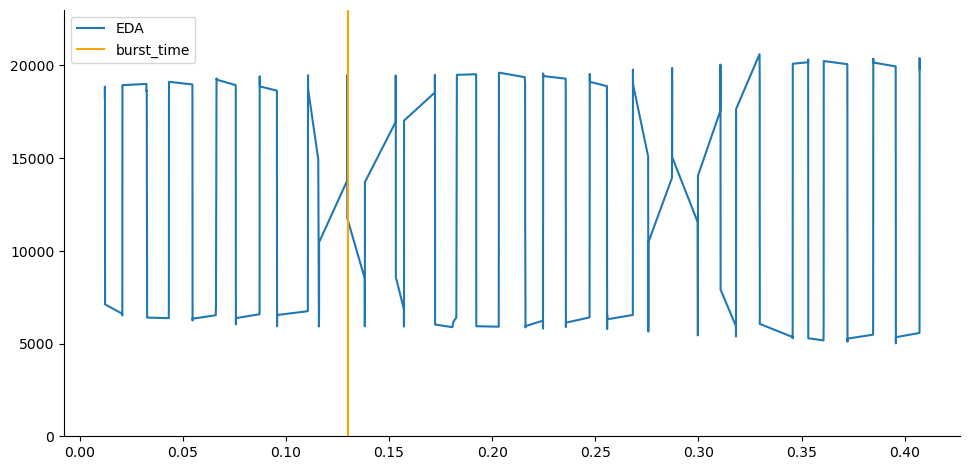

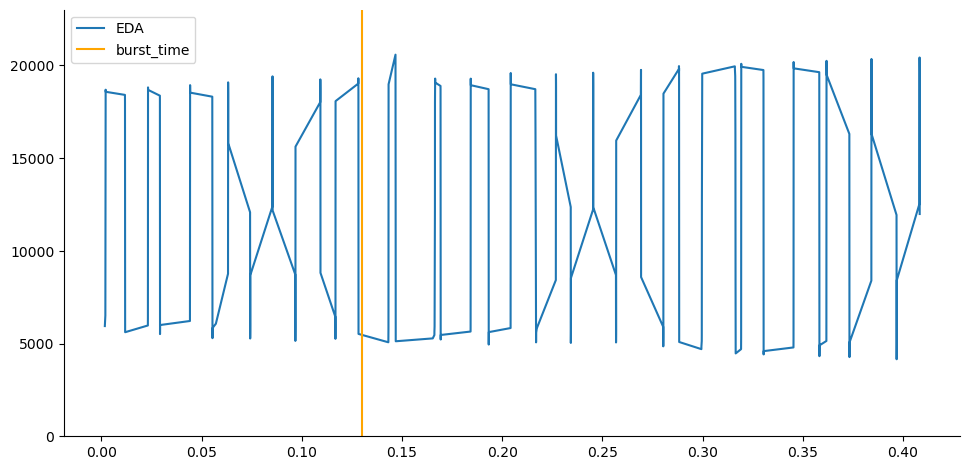

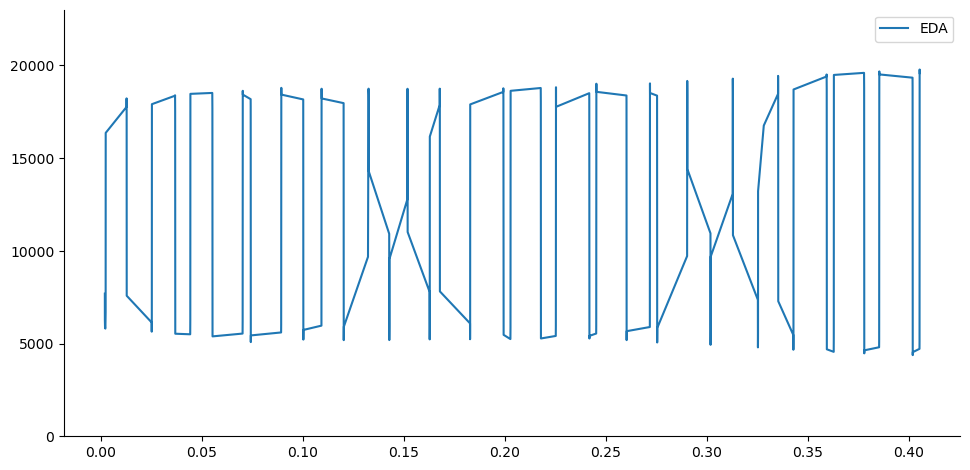

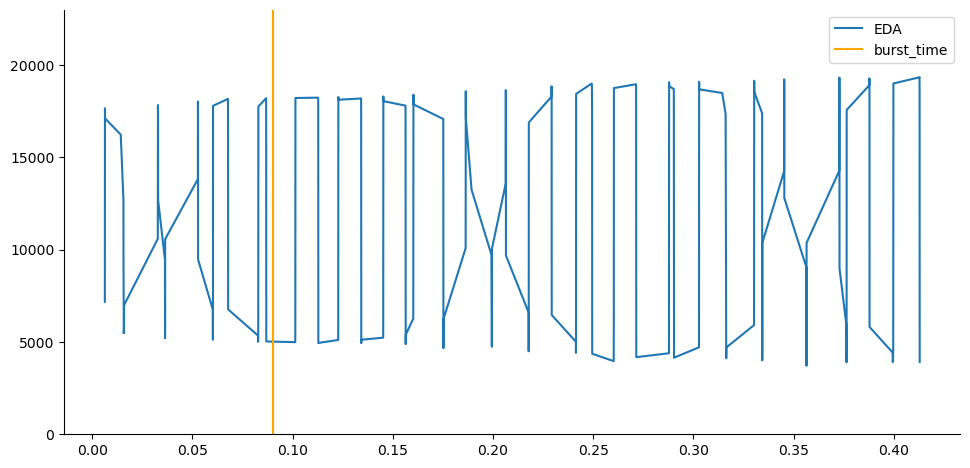

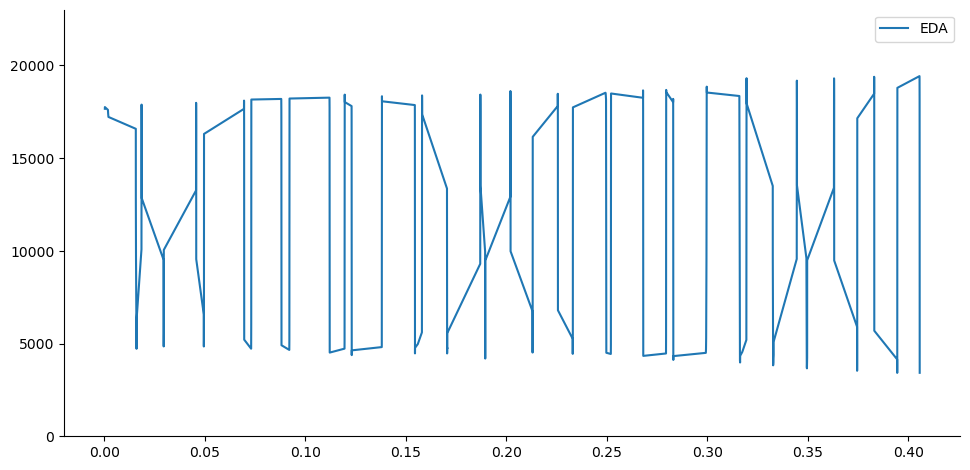

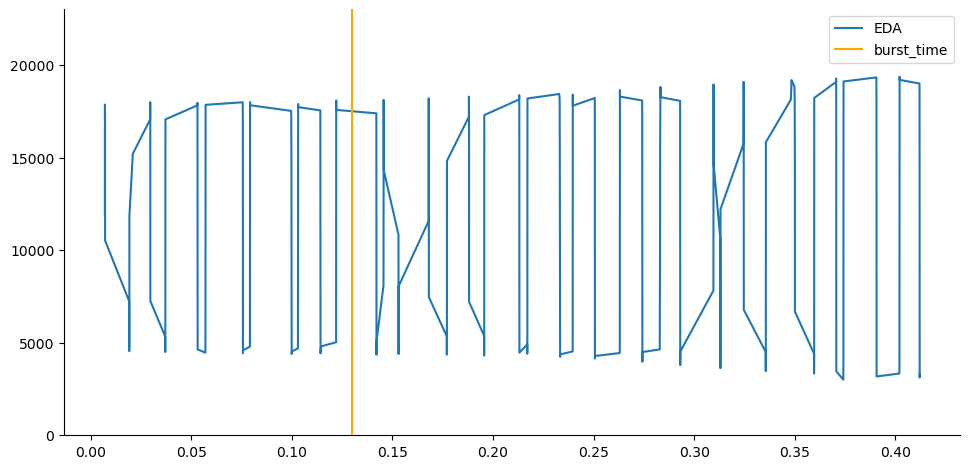

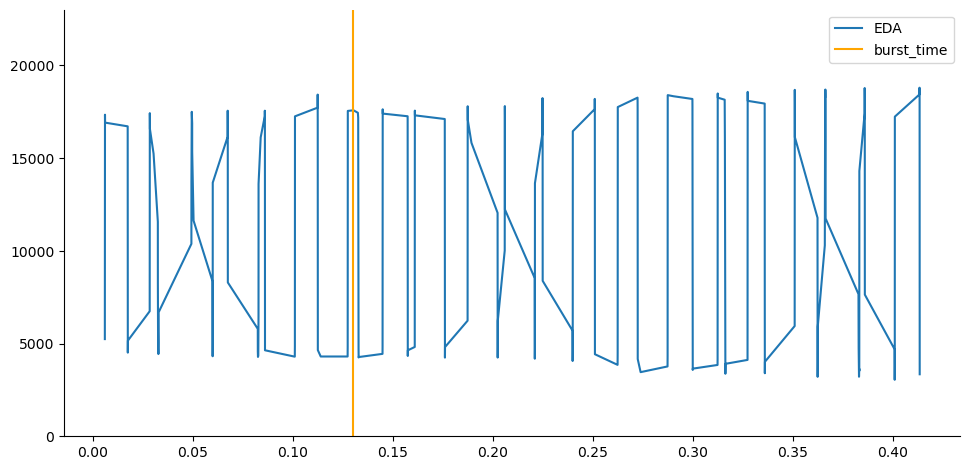

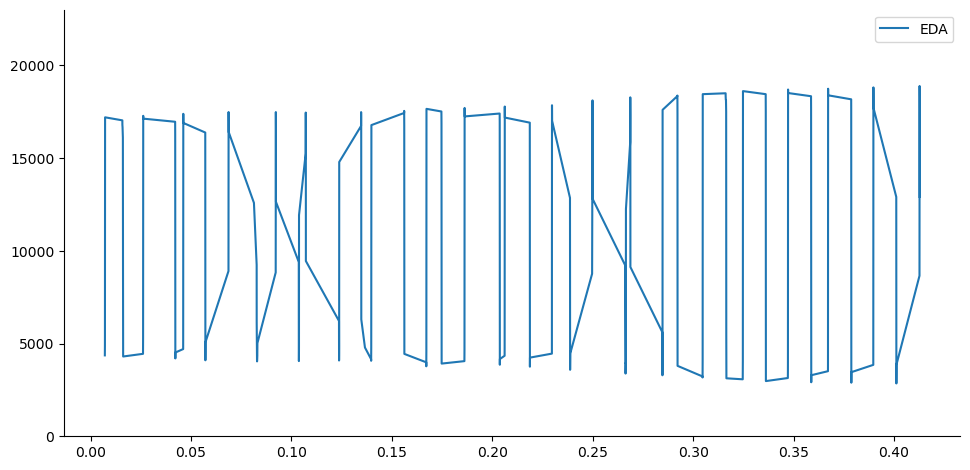

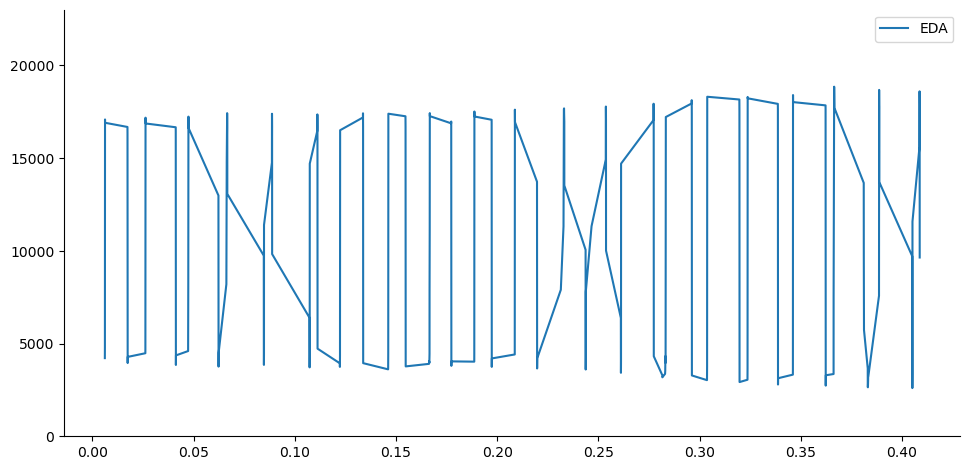

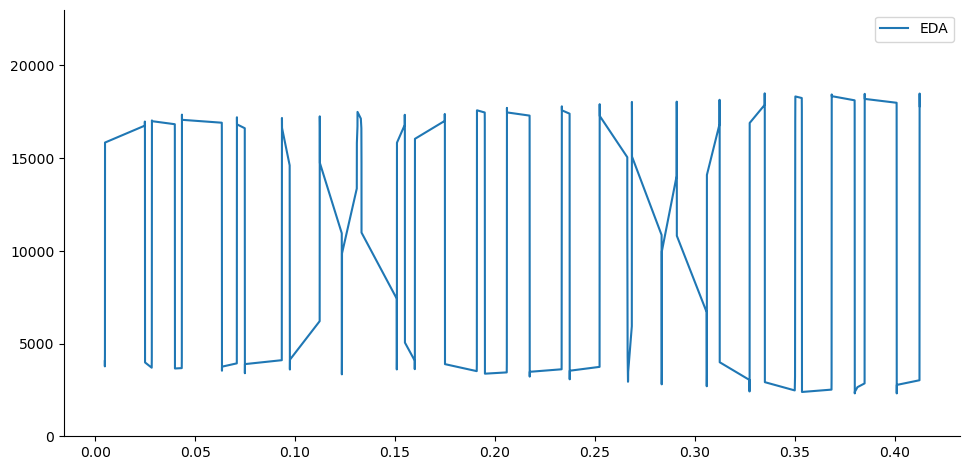

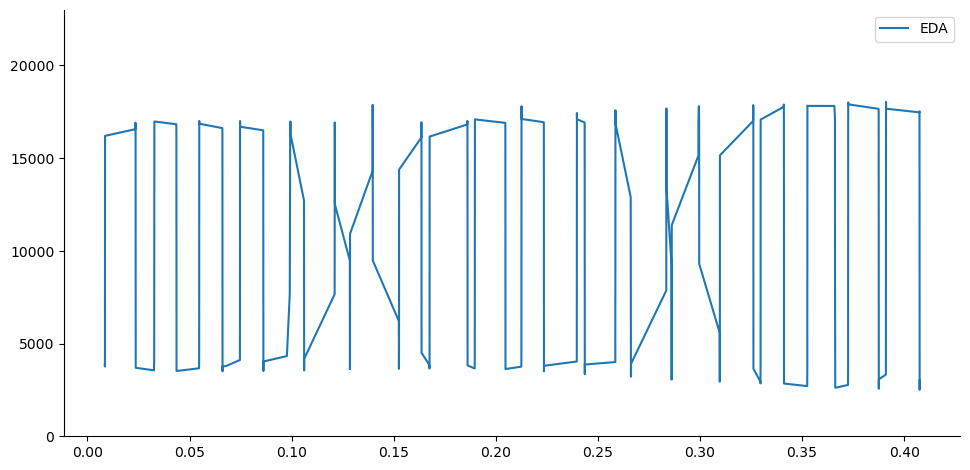

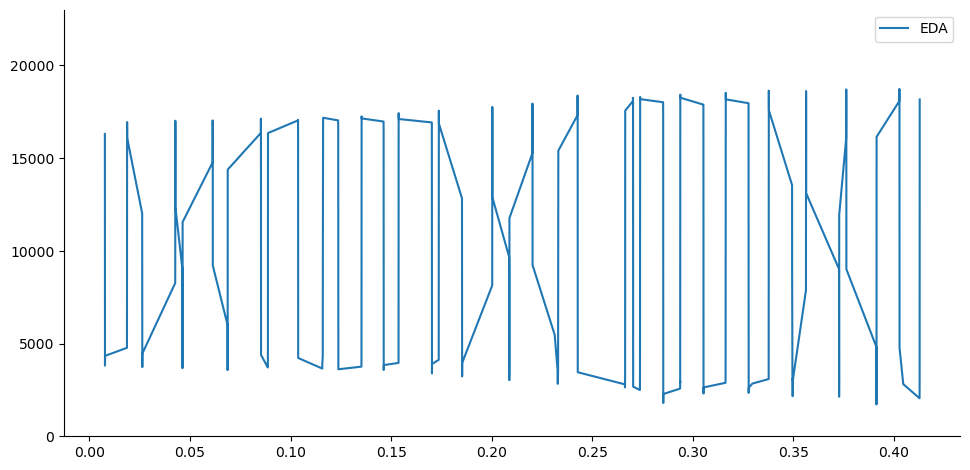

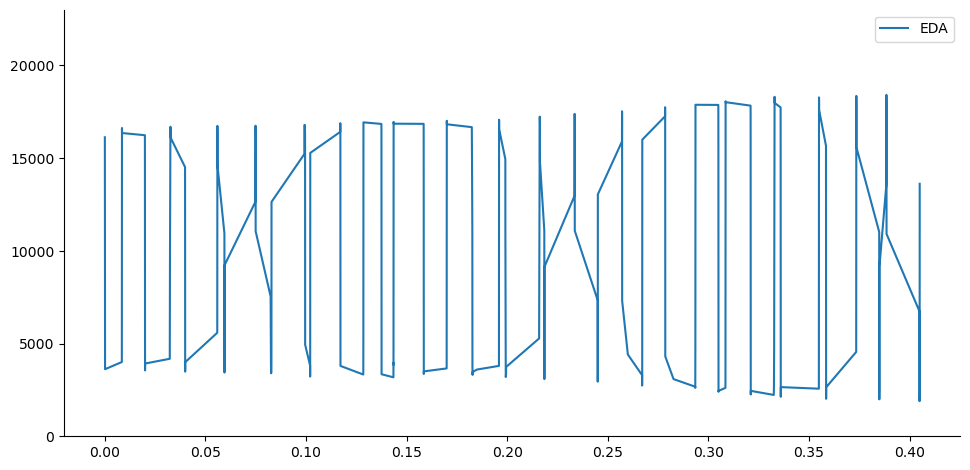

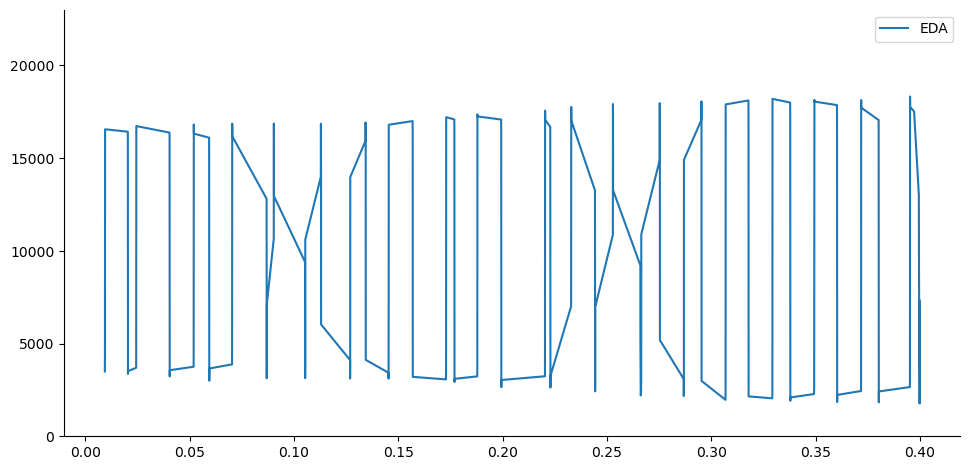

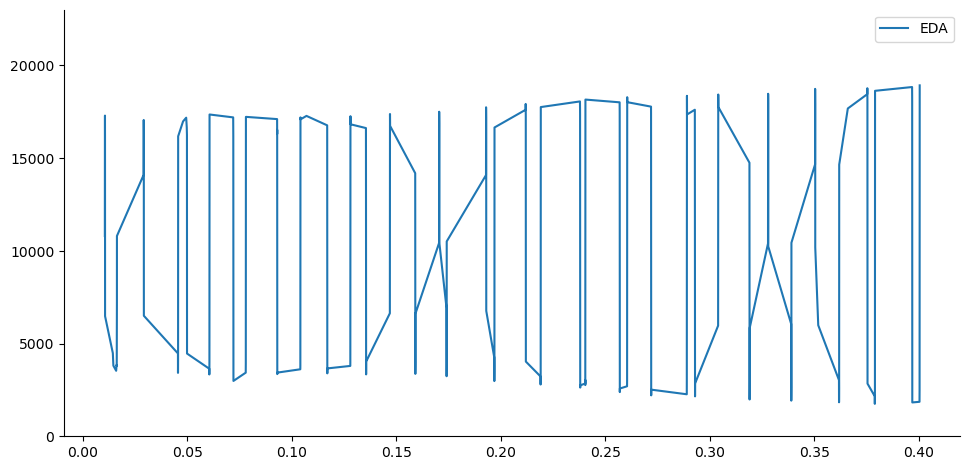

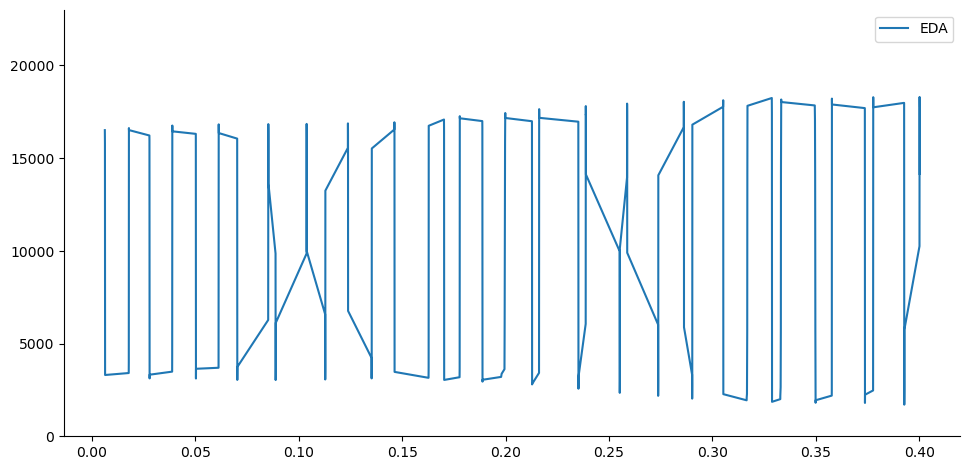

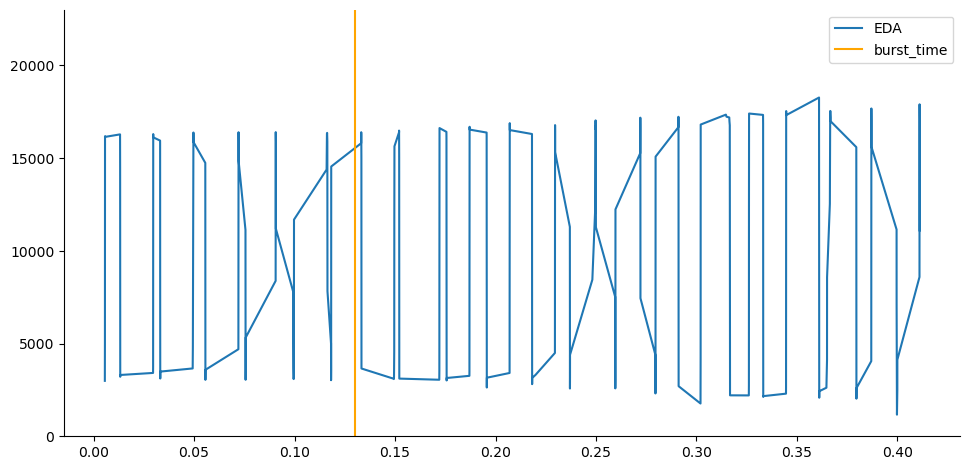

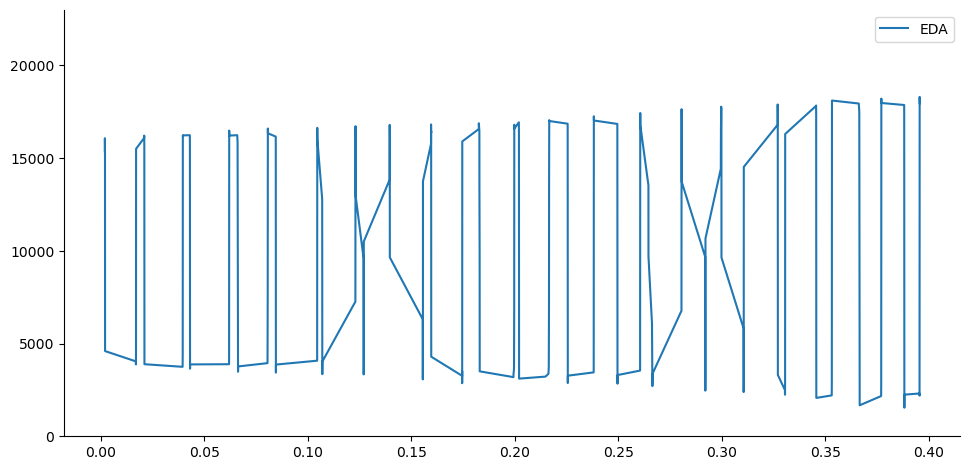

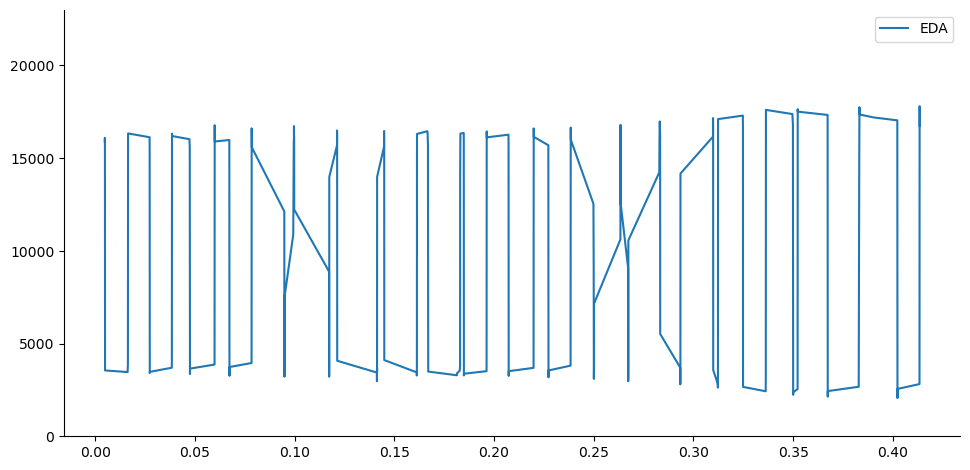

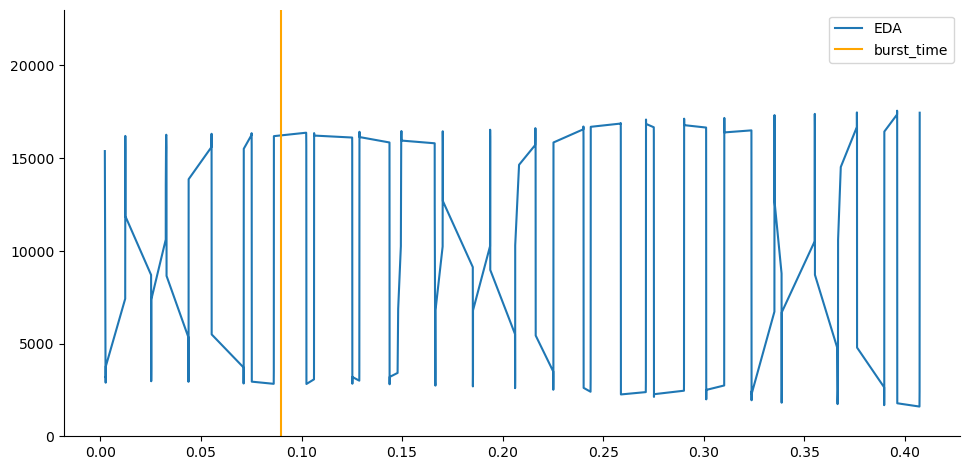

In [99]:
# Plot EDA data with burst_time
for i, t in trials.iterrows():
    if i < 20 or i> 40:
        continue
    eda_data = np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_nr']}_fe.npy", allow_pickle=True)
    #f_data = np.load(f"./data/celine/main/b{t['block_nr']}_t{t['trial_number']}_fm.npy")
    
    t_plt = sb.relplot(kind="line", x=eda_data[1][0], y=eda_data[0][0], aspect=2, label="EDA")
    t_plt.set(ylim=(0, 23000))
    if t['trial_burst_time'] != 0:
        plt.axvline(x=t['trial_burst_time'], color='orange', label="burst_time")
        
    plt.legend()

## PR and Force

In [109]:
trials_pr_answer = (trials[['trial_burst_force', 'pr_distance','subj_answer']][trials['subj_answer'].notnull()])
#trials_pr_answer['trial_burst_force'] = trials_pr_answer['trial_burst_force'].abs()
trials_pr_answer_bin = trials_pr_answer.copy()
trials_pr_answer_bin["trial_burst_force"] = trials_pr_answer_bin.trial_burst_force.apply(lambda x: 1 if x != 0 else 0)

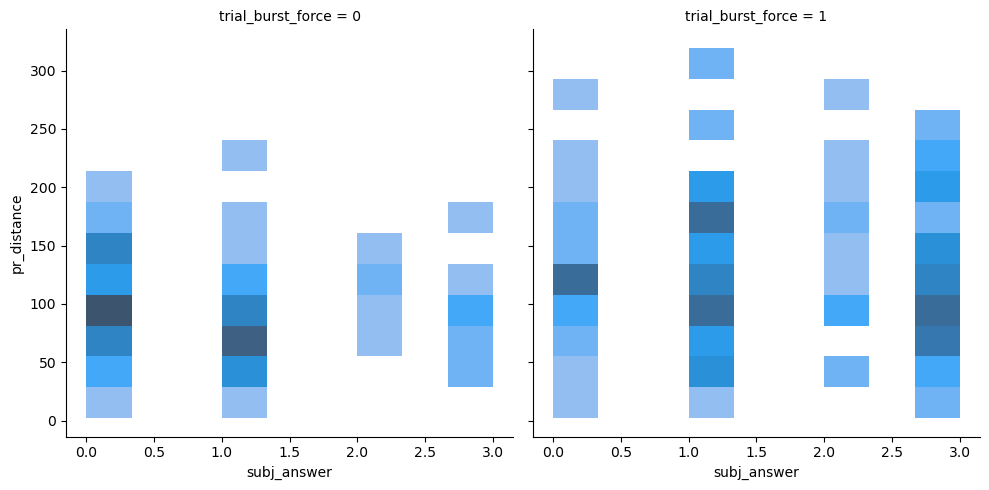

In [104]:
sb.displot(data=trials_pr_answer_bin, x="subj_answer", y="pr_distance", col="trial_burst_force")

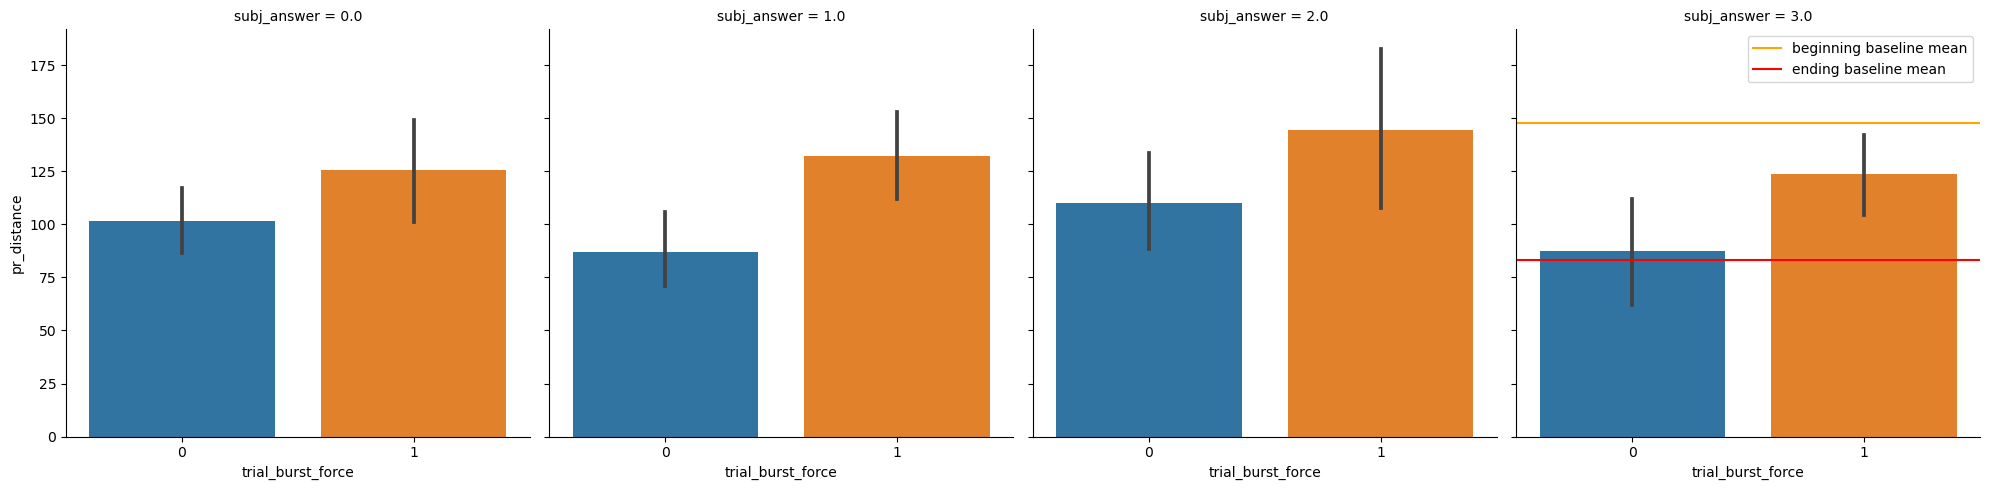

In [131]:
# Vergleichen von pr_dist normal mit pr_dist unter force

axes = sb.catplot(data=trials_pr_answer_bin, kind="bar", x="trial_burst_force", y="pr_distance", col="subj_answer")

base1 = pd.read_csv("./data/celine/beginn/trials.csv")
base1_mean = base1["pr_distance"].mean()
base2 = pd.read_csv("./data/celine/end/trials.csv")
base2_mean = base2["pr_distance"].mean()

plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
plt.legend()

## PR over time

[(0.0, 400.0)]

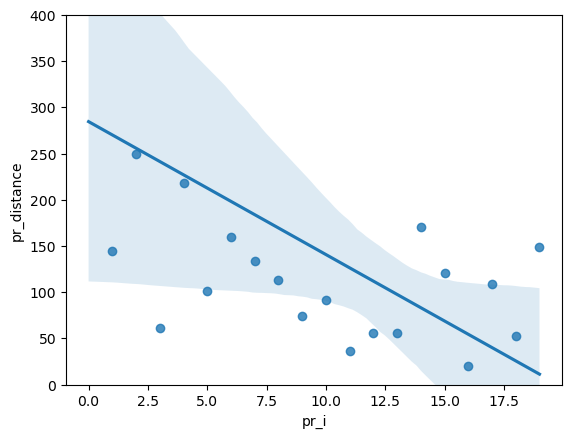

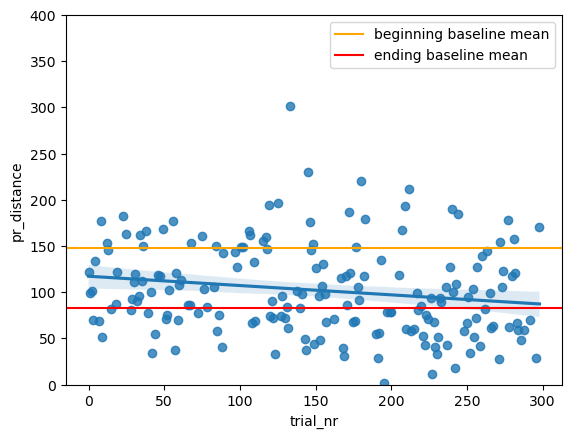

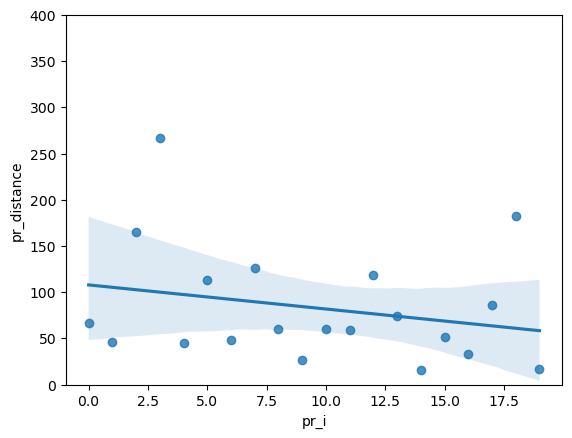

In [130]:
plt.figure(0)
a = sb.regplot(data=base1, x='pr_i', y="pr_distance")#, kind="line")
a.set(ylim=(0,400))
plt.figure(2)
d = sb.regplot(data=trials[trials["trial_burst_force"] == 0], x='trial_nr', y="pr_distance")#, kind="line")
d.set(ylim=(0,400))
plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
plt.legend()
plt.figure(1)
b = sb.regplot(data=base2, x='pr_i', y="pr_distance")#, kind="line")
b.set(ylim=(0,400))

## PR targets

In [ ]:
# TODO